# Hidden Markov models
The Unistroke alphabet, closely related to Graffiti, is an essentially single-stroke shorthand handwriting recognition system used in PDAs. The data set is composed of 50 × 6 time-trajectories representing the drawing of letters A, E, H, L, O and Q in a plane.


## 4.1 Lab work

Here you will focus on discriminating letters A and L, you may ignore the other four letters if you want.

#### *1. Define an HMC model (number of states, every parameter, ...) and simulate some trajectories, until it resembles letter Λ up to some Gaussian noise. Hint: you may use a differential representation of the signal. If you want to output $\mathbf{x_1, ... , x_n}$, simulate $\mathbf{y_1 = x_1 − 0, y_2 = x_2 − x_1, ..., y_2 = x_n − x_{n−1}}$.*

We begin by importing all the modules necessary for the whole lab.

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn import hmm
from sklearn.model_selection import KFold
import warnings
from msmbuilder.hmm import VonMisesHMM
warnings.filterwarnings("ignore")
%matplotlib inline

Whe choose to pick a model with two states. It seems natural because in our case the letter A is composed by two straight lines plus a noise. It must always start in the first stage, have a small probability of going to the second stage, and never go back. To form the letter A, the first stage should point up and right, and the second stage should point down and right. The covariance matrix must have values small enough so that the noise will not be too strong.

In [3]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from hmmlearn import hmm

model = GaussianHMM(n_components=2, covariance_type="full")
model.startprob_ = np.array([1, 0])
model.transmat_ = np.array([[0.95, 0.05],
                             [0, 1]])
model.means_ = np.array([[1.0, 1.0], [1.0, -1.0]])
model.covars_ = np.tile(np.identity(2)/10, (2, 1, 1))
np.random.seed(5)
model._check()
Y, Z = model.sample(25)

2


#### *2. Develop some procedure to plot a real trajectory $\mathbf{X_{n_1} = (x_1, ... , xn) ∈ (R^2)^n}$. Connect successive points with segments, but do not care about potential loss of temporal information in the produced figures. The trajectory will be a reverse letter but you may ignore this too. Include such figure in your report*

To plot a trajectory from the y's:

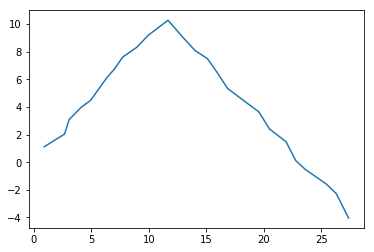

In [4]:
def print_letter_diff(df):
    X = np.cumsum(df, axis = 0)
    plt.plot(X[:,0], X[:,1])
    
print_letter_diff(Y)

To plot a trajectory from the x's:

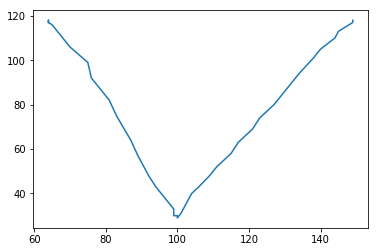

In [5]:
a01 = pd.read_csv("Unistroke/A01.txt", "\t")
plt.plot(a01.iloc[:,0], a01.iloc[:,1])

#### *3. Normalize the trajectories by computing $\mathbf{y_t = \frac{x_t − x_{t−1}}{∥xt − xt−1∥^2}}$ for $\mathbf{t = 2, ... , n}$. Estimate an HMC model with all the normalized trajectories for letter A, using bivariate Gaussian emission distribution. Justify your choice for the number of states. Provide the estimates and comment them.*

Let's compute the array that will be input for our HMC model:

In [88]:
def remove_zero_movements(df):
    X_now = df
    X_now = X_now.subtract(X_now.shift(1))#.drop(X_now.index[0]) #calculate differences
    X_now = np.abs(X_now)
    zero_movs = np.where(np.any(np.array([np.sum(X_now, axis = 1)])==0, axis= 0))[0]
    zero_movs = zero_movs[1:]
#     df = df.drop(df.index[0])
    df = df.drop(df.index[zero_movs])
    return df

In [89]:
def create_normalized_difference(X):
    X = X.subtract(X.shift(1)).drop(X.index[0]) #calculate differences
    X = X.div(np.sqrt((X*X).sum(axis=1)), axis=0)
    X = np.array(X)  
    return(X)

In [90]:
def create_gaussian_hmm_training_set(letter, file_indices):
    files = ["Unistroke/" + letter +str(i).zfill(2)+".txt" for i in file_indices] 
    Xa = np.array([[0,0]])
    lengths = np.array([0])

    for file in files:
        X_now = pd.read_csv(file, "\t")
        X_now = remove_zero_movements(X_now)
        X_now = create_normalized_difference(X_now)
        Xa = np.concatenate([Xa, X_now])
        lengths = np.concatenate([lengths, [len(X_now)]])

    Xa = np.delete(Xa, (0), axis = 0)
    lengths = np.delete(lengths, (0))
    return Xa, lengths

As we said before, the choice of 2 states comes naturally for this HMC. The drawings are composed of two lines, which we expect to be the two states of the HMC model. This will give us a interpretable model and we will be able to confirm our hypothesized model in the first question

In [9]:
X_a, lengths_a = create_gaussian_hmm_training_set("A", range(1,51))
hmm_model_a = hmm.GaussianHMM(n_components=2).fit(X_a, lengths_a)  

**Initial states:**

In [10]:
hmm_model_a.startprob_

array([ 0.12,  0.88])

**Transition matrix:**

In [11]:
hmm_model_a.transmat_

array([[ 0.96341681,  0.03658319],
       [ 0.14135932,  0.85864068]])

**Means:**

In [12]:
hmm_model_a.means_

array([[-0.37377552,  0.85278103],
       [-0.44494029, -0.87132413]])

**Covariance Matrices:**

In [13]:
hmm_model_a.covars_.round(4)

array([[[ 0.0838,  0.    ],
        [ 0.    ,  0.0493]],

       [[ 0.0383,  0.    ],
        [ 0.    ,  0.0045]]])

We see that we the fitted model is very similar to what we thought before. Of course, the means have different signs because we trained the model with upside-down letters. Also, we thought about +-45 degrees slopes (since we used the same length for the x and y components), which is not what people actually do when writing the letter A. We can see that the mean values for the y-axis are bigger (in absolute value) than for the x-values, which means that the slopes of the line segments that compose the A's are more vertical than previously thought

#### *4. Same question as above for letter L. You may use the python hmmlearn or another library of your choice.*

In [14]:
X_l, lengths_l = create_gaussian_hmm_training_set("L", range(1,51))
hmm_model_l = hmm.GaussianHMM(n_components=2).fit(X_l, lengths_l)  

**Initial states:**

In [15]:
hmm_model_l.startprob_

array([ 0.85998433,  0.14001567])

**Transition matrix:**

In [16]:
hmm_model_l.transmat_

array([[ 0.85867609,  0.14132391],
       [ 0.05163217,  0.94836783]])

**Means:**

In [17]:
hmm_model_l.means_

array([[ 0.00902734,  0.99660676],
       [-0.83222274,  0.06868405]])

**Covariance Matrices:**

In [18]:
hmm_model_l.covars_

array([[[  6.67989510e-03,   0.00000000e+00],
        [  0.00000000e+00,   6.02674693e-05]],

       [[  2.23001721e-01,   0.00000000e+00],
        [  0.00000000e+00,   7.97318923e-02]]])

We can see again that the values for the means are what we naturally would expect: a practically vertical and a practically horizontal lines. The covariances in this case have also much smaller coefficients, which could be because the drawing of the letter L is simpler and less prone to noise. Also, for the letter A there is no "correct slope". People can draw A's in a lot of different ways and they would still be A's. The letter L is more constrained, given that it has to be composed of a vertical and a horizontal lines.

#### *5. Use the Viterbi algorithm on A1.txt and plot the unnormalized sequence using different colours for different states.*

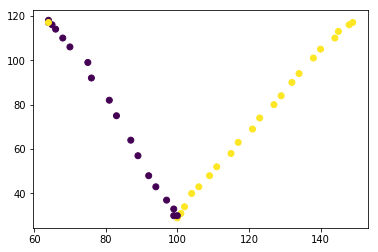

In [19]:
a01 = pd.read_csv("Unistroke/A01.txt", "\t")
a01 = remove_zero_movements(a01)
a01diff = create_normalized_difference(a01)
color = hmm_model_a.predict(a01diff)

plt.scatter(a01.iloc[1:,0], a01.iloc[1:,1], c = color)

#### *6. Propose and implement a graphical (visual) method to validate the assumption of bivariate Gaussian emission distribution. What to think about this assumption?*

A good way to evaluate the assumption is by looking at the scatter plot of the data with the colors indicating the states and also by looking at the X and Y histograms for the different states. On top of those, we overlapped the distributions given by the trained models and compared those. 

We can immediately see below that the distributions of the data do not look like Gaussian distributions. Except maybe by the purple class for the letter L. By looking at the histograms, in A we see patterns a bit closer to Gaussians, but for L they are extremely distinct. We therefore conclude that the assumption is not good.

In [20]:
files  = ["Unistroke/A"+str(i).zfill(2)+".txt" for i in range(1,51)] 
X = np.array([[0,0]])
Y = np.array([[0,0]])
colors = np.array([0])
for file in files:
    X_now = pd.read_csv(file, "\t")
    X_now = remove_zero_movements(X_now)
    Y_now = create_normalized_difference(X_now)
    color = hmm_model_a.predict(Y_now)
    X = np.concatenate([X, X_now.iloc[1:,:]])
    Y = np.concatenate([Y, Y_now])
    colors = np.concatenate([colors, color])
X = X[1:]
Y = Y[1:]
colors = colors[1:]
# Xl = np.delete(Xl, (0), axis = 0)
# colors = np.delete(colors, (0))

Text(0.5,1,u'All the data from letters A and their states by HMM \n with bivariate Gaussian emission distribution')

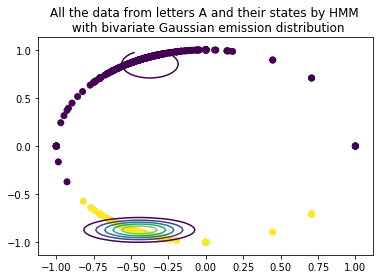

In [21]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

delta = 0.025
x = np.arange(-1.0, 1.0, delta)
y = np.arange(-1.0, 1.0, delta)
X, Y2 = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y2, np.sqrt(hmm_model_a.covars_[0][0][0]), np.sqrt(hmm_model_a.covars_[0][1][1]), hmm_model_a.means_[0][0], hmm_model_a.means_[0][1])
Z2 = mlab.bivariate_normal(X, Y2, np.sqrt(hmm_model_a.covars_[1][0][0]), np.sqrt(hmm_model_a.covars_[1][1][1]), hmm_model_a.means_[1][0], hmm_model_a.means_[1][1])
# difference of Gaussians
Z = (Z2 + Z1)

plt.figure()
CS = plt.contour(X, Y2, Z)

plt.scatter(Y[:,0],Y[:,1], c = colors)
plt.title("All the data from letters A and their states by HMM \n with bivariate Gaussian emission distribution")

Text(0.5,1,u'A - Histogram of x-axis for state 1')

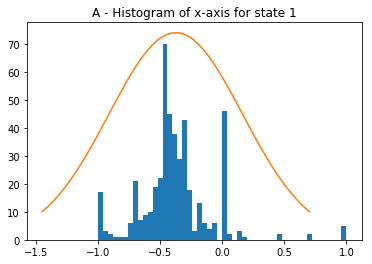

In [22]:
plt.hist(Y[colors == 0,0], bins = 50)
mu = hmm_model_a.means_[0][0]
variance =  np.sqrt(hmm_model_a.covars_[0][0][0])
sigma = np.sqrt(variance)
x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
plt.plot(x,100*mlab.normpdf(x, mu, sigma))
plt.title("A - Histogram of x-axis for state 1")

Text(0.5,1,u'A - Histogram of y-axis for state 1')

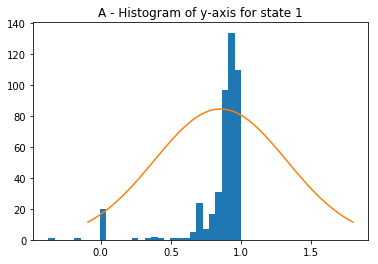

In [23]:
plt.hist(Y[colors == 0,1], bins = 30)
mu = hmm_model_a.means_[0][1]
variance =  np.sqrt(hmm_model_a.covars_[0][1][1])
sigma = np.sqrt(variance)
x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
plt.plot(x,100*mlab.normpdf(x, mu, sigma))
plt.title("A - Histogram of y-axis for state 1")

Text(0.5,1,u'A - Histogram of x-axis for state 2')

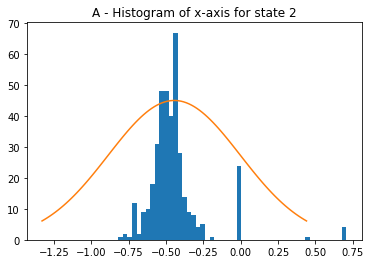

In [24]:
plt.hist(Y[colors == 1,0], bins = 50)
mu = hmm_model_a.means_[1][0]
variance =  np.sqrt(hmm_model_a.covars_[1][0][0])
sigma = np.sqrt(variance)
x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
plt.plot(x,50*mlab.normpdf(x, mu, sigma))
plt.title("A - Histogram of x-axis for state 2")

Text(0.5,1,u'A - Histogram of y-axis for state 2')

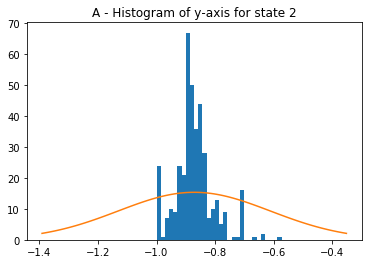

In [25]:
plt.hist(Y[colors == 1,1], bins = 30)
mu = hmm_model_a.means_[1][1]
variance =  np.sqrt(hmm_model_a.covars_[1][1][1])
sigma = np.sqrt(variance)
x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
plt.plot(x,10*mlab.normpdf(x, mu, sigma))
plt.title("A - Histogram of y-axis for state 2")

In [26]:
files  = ["Unistroke/L"+str(i).zfill(2)+".txt" for i in range(1,51)] 
X = np.array([[0,0]])
Y = np.array([[0,0]])
colors = np.array([0])
for file in files:
    X_now = pd.read_csv(file, "\t")
    X_now = remove_zero_movements(X_now)
    Y_now = create_normalized_difference(X_now)
    color = hmm_model_l.predict(Y_now)
    X = np.concatenate([X, X_now.iloc[1:,:]])
    Y = np.concatenate([Y, Y_now])
    colors = np.concatenate([colors, color])
X = X[1:]
Y = Y[1:]
colors = colors[1:]
# Xl = np.delete(Xl, (0), axis = 0)
# colors = np.delete(colors, (0))

Text(0.5,1,u'All the data from letters L and their states by HMM \n with bivariate Gaussian emission distribution')

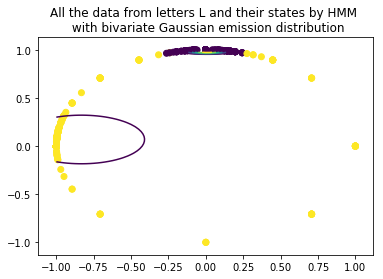

In [27]:
delta = 0.025
x = np.arange(-1.0, 1.0, delta)
y = np.arange(-1.0, 1.0, delta)
X, Y2 = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y2, np.sqrt(hmm_model_l.covars_[0][0][0]), np.sqrt(hmm_model_l.covars_[0][1][1]), hmm_model_l.means_[0][0], hmm_model_l.means_[0][1])
Z2 = mlab.bivariate_normal(X, Y2, np.sqrt(hmm_model_l.covars_[1][0][0]), np.sqrt(hmm_model_l.covars_[1][1][1]), hmm_model_l.means_[1][0], hmm_model_l.means_[1][1])
# difference of Gaussians
Z = (Z2 + Z1)

plt.figure()
CS = plt.contour(X, Y2, Z)
plt.scatter(Y[:,0],Y[:,1], c = colors)
          
plt.title("All the data from letters L and their states by HMM \n with bivariate Gaussian emission distribution")

Text(0.5,1,u'L - Histogram of x-axis for state 1')

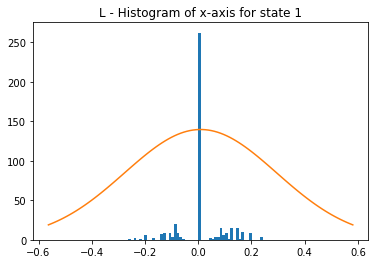

In [28]:
plt.hist(Y[colors == 0,0], bins = 50)
mu = hmm_model_l.means_[0][0]
variance =  np.sqrt(hmm_model_l.covars_[0][0][0])
sigma = np.sqrt(variance)
x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
plt.plot(x,100*mlab.normpdf(x, mu, sigma))
plt.title("L - Histogram of x-axis for state 1")

Text(0.5,1,u'L - Histogram of y-axis for state 1')

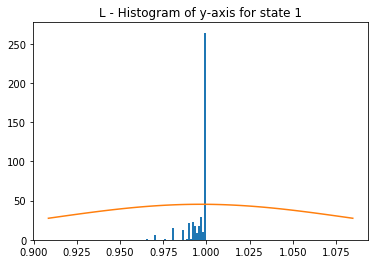

In [29]:
plt.hist(Y[colors == 0,1], bins = 30)
mu = hmm_model_l.means_[0][1]
variance =  np.sqrt(hmm_model_l.covars_[0][1][1])
sigma = np.sqrt(variance)
x = np.linspace(mu - 1*sigma, mu + 1*sigma, 100)
plt.plot(x,10*mlab.normpdf(x, mu, sigma))
plt.title("L - Histogram of y-axis for state 1")

Text(0.5,1,u'L - Histogram of x-axis for state 2')

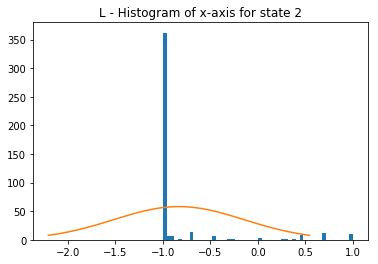

In [30]:
plt.hist(Y[colors == 1,0], bins = 50)
mu = hmm_model_l.means_[1][0]
variance =  np.sqrt(hmm_model_l.covars_[1][0][0])
sigma = np.sqrt(variance)
x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
plt.plot(x,100*mlab.normpdf(x, mu, sigma))
plt.title("L - Histogram of x-axis for state 2")

Text(0.5,1,u'L - Histogram of y-axis for state 2')

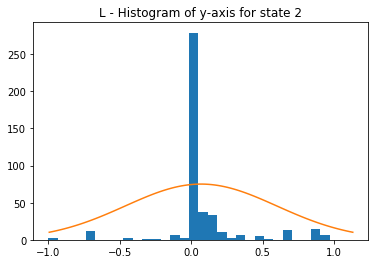

In [31]:
plt.hist(Y[colors == 1,1], bins = 30)
mu = hmm_model_l.means_[1][1]
variance =  np.sqrt(hmm_model_l.covars_[1][1][1])
sigma = np.sqrt(variance)
x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
plt.plot(x,100*mlab.normpdf(x, mu, sigma))
plt.title("L - Histogram of y-axis for state 2")

### 4.2 Mandatory additional questions
The aim of this part is to compare von Mises and Gaussian emission distributions.

##### 1. Transform the data to angular data. Implement von Mises emission distributions (including formal computations into the report) and compare the results with bivariate Gaussians.

In [32]:
def create_gaussian_hmm_training_set(letter, file_indices):
    files = ["Unistroke/" + letter +str(i).zfill(2)+".txt" for i in file_indices] 
    Xa = np.array([[0,0]])
    lengths = np.array([0])

    for file in files:
        X_now = pd.read_csv(file, "\t")
        X_now = remove_zero_movements(X_now)
        X_now = create_normalized_difference(X_now)
        Xa = np.concatenate([Xa, X_now])
        lengths = np.concatenate([lengths, [len(X_now)]])

    Xa = np.delete(Xa, (0), axis = 0)
    lengths = np.delete(lengths, (0))
    return Xa, lengths

In [33]:
def create_vonmises_hmm_training_set(letter, file_indices):
    files = ["Unistroke/" + letter +str(i).zfill(2)+".txt" for i in file_indices] 
    X = []
    lengths = np.array([0])

    for file in files:
        X_now = pd.read_csv(file, "\t")
        X_now = remove_zero_movements(X_now)
        X_now = create_normalized_difference(X_now)
        X_now = np.arctan2(X_now[:,1], X_now[:,0])
        X_now = X_now.reshape((-1,1))
        X.append(X_now)

    return X

### Letter A

In [34]:
X_a_vm = create_vonmises_hmm_training_set("A", range(1,51))
hmm_vm_a = VonMisesHMM(n_states = 2)
hmm_vm_a.fit(X_a_vm)

**Initial states:**

In [35]:
hmm_vm_a.populations_

array([ 0.80544268,  0.19455732])

**Transition matrix:**

In [36]:
hmm_vm_a.transmat_

array([[ 0.96618469,  0.03381531],
       [ 0.13999111,  0.86000889]])

**Means: **

In [37]:
hmm_vm_a.means_

array([[ 1.98020124],
       [-2.05350566]], dtype=float32)

(-1, 1)

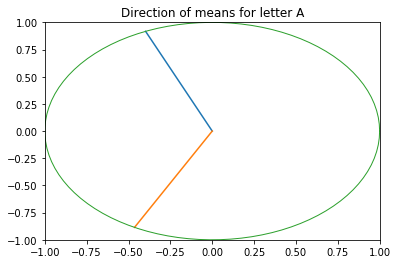

In [38]:
plt.plot([0, np.cos(hmm_vm_a.means_)[0]], [0, np.sin(hmm_vm_a.means_)[0]])
plt.plot([0, np.cos(hmm_vm_a.means_)[1]], [0, np.sin(hmm_vm_a.means_)[1]])
t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1)
plt.title("Direction of means for letter A")
plt.xlim((-1,1))
plt.ylim((-1,1))

**Kappas:**

In [39]:
hmm_vm_a.kappas_

array([[  6.13578059],
       [ 34.55107525]])

### Letter L

In [40]:
X_l_vm = create_vonmises_hmm_training_set("L", range(1,51))
hmm_vm_l = VonMisesHMM(n_states = 2)
hmm_vm_l.fit(X_l_vm)

**Initial states:**

In [41]:
hmm_vm_l.populations_

array([ 0.81965271,  0.18034729])

**Transition matrix:**

In [42]:
hmm_vm_l.transmat_

array([[ 0.97356159,  0.02643841],
       [ 0.12015879,  0.87984121]])

**Means: **

In [43]:
hmm_vm_l.means_

array([[ 3.07094002],
       [ 1.55680788]], dtype=float32)

(-1, 1)

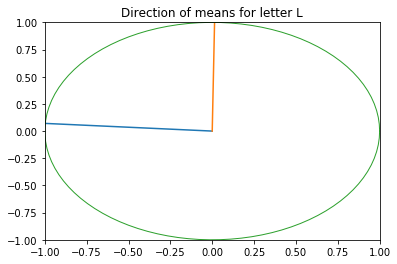

In [44]:
plt.plot([0, np.cos(hmm_vm_l.means_)[0]], [0, np.sin(hmm_vm_l.means_)[0]])
plt.plot([0, np.cos(hmm_vm_l.means_)[1]], [0, np.sin(hmm_vm_l.means_)[1]])
t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1)
plt.title("Direction of means for letter L")
plt.xlim((-1,1))
plt.ylim((-1,1))

**Kappas:**

In [45]:
hmm_vm_l.kappas_

array([[   3.64864042],
       [ 106.21469148]])

###### 2. Compute a 5-fold cross-validated classification error with both families of emission distributions (for the moment, only consider classes A and L.)

#### Gaussian:

In [250]:
indices = np.array(range(1,51))
kf = KFold(n_splits=5)
letters = ["A", "L"]
states = [2, 2]
k = 0
cvscore = np.zeros(5)
for inTrain, inTest in kf.split(indices):
    correct = 0
    models = []
    for l in range(0,len(letters)):
        X, lengths = create_gaussian_hmm_training_set(letters[l], indices[inTrain])
        hmm_model = hmm.GaussianHMM(n_components=states[l]).fit(X, lengths)
        models.append(hmm_model)
    for l in range(0,len(letters)):
        for index in inTest:
            test = pd.read_csv("Unistroke/" + letters[l] +str(indices[index]).zfill(2)+".txt", "\t")
            test = remove_zero_movements(test)
            test = create_normalized_difference(test)
            score = []
            for model in models:
                score.append(model.score(test))
            if l == np.argmax(score):
                correct+=1
    cvscore[k] = 1.*correct/(len(inTest)*len(letters))
    print("Fold " + str(k) + " accuracy: ", cvscore[k])
    k+=1

print("5-fold CV accuracy:", np.mean(cvscore))

('Fold 0 accuracy: ', 1.0)
('Fold 1 accuracy: ', 1.0)
('Fold 2 accuracy: ', 1.0)
('Fold 3 accuracy: ', 1.0)
('Fold 4 accuracy: ', 1.0)
('5-fold CV accuracy:', 1.0)


#### Von Mises:

In [252]:
indices = np.array(range(1,51))
kf = KFold(n_splits=5)
letters = ["A", "L"]
states = [2, 2]
k = 0
cvscore = np.zeros(5)
for inTrain, inTest in kf.split(indices):
    correct = 0
    models = []
    for l in range(0,len(letters)):
        X = create_vonmises_hmm_training_set(letters[l], indices[inTrain])
        hmm_model = VonMisesHMM(n_states=states[l]).fit(X)
        models.append(hmm_model)
    for l in range(0,len(letters)):
        for index in inTest:
            test = pd.read_csv("Unistroke/" + letters[l] +str(indices[index]).zfill(2)+".txt", "\t")
            test = remove_zero_movements(test)
            test = create_normalized_difference(test)
            test = np.arctan2(test[:,1], test[:,0])
            test = test.reshape((-1,1))
            score = []
            for model in models:
                score.append(model.score([test]))
            if l == np.argmax(score):
                correct+=1
    cvscore[k] = 1.*correct/(len(inTest)*len(letters))
    print("Fold " + str(k) + " accuracy: ", cvscore[k])
    k+=1

print("5-fold CV accuracy:", np.mean(cvscore))

('Fold 0 accuracy: ', 1.0)
('Fold 1 accuracy: ', 1.0)
('Fold 2 accuracy: ', 1.0)
('Fold 3 accuracy: ', 1.0)
('Fold 4 accuracy: ', 1.0)
('5-fold CV accuracy:', 1.0)


### 4.3 Optional additional questions

##### 1. Give a formal definition of consistent estimators of the number of states in a HMM. Write some state-of-the-art on that topic, choose one of the references therein, justifying your choice. Provide a one-page description of the approach developed in that reference.


A consistent estimator of the number of states in a HMM one that, under infinite data, will provide the true optimal number of parameters for the HMM. We were not able or did not have time to go further and pick a consistent method. Instead, we decided to use a popular method for the following questions: BIC.

#### 2. Imagine, describe and implement a protocol to evaluate consistency of any arbitrary estimator of the number of states. Test this protocol on HMM with von Mises distributions, using the estimator chosen in the previous question.

#### 3. Apply the chosen approach to estimate the number of states in the real data set of part 4.1 (with mixture of von Mises distributions), considering now the 6 letters A, E, H, L, O and Q.


In [ ]:
letters = ["A", "L", "E", "Q", "O", "H"]
max_states = 12
bic = np.zeros([max_states,len(letters)])
for i in range(1,max_states):
    for l in range(0,len(letters)):
        X_a = create_vonmises_hmm_training_set(letters[l], range(1,51))
        hmm_model_a = VonMisesHMM(n_states=i).fit(X_a)
        M = 2
        N = i
        n_params = 2*N + N*(N-1) + N - 1
        bic[i,l] = -2*hmm_model_a.score(X_a) + n_params*np.log(len(np.vstack(X_a)))
    #print(bic[i,:].round())

In [ ]:
Values found with BIC:

In [ ]:
np.argmin(bic[1:14,:], axis = 0)+1

In [ ]:
pd.DataFrame(bic[1:], columns=letters).plot()
plt.title("BIC with respect to the number of states \n for Von Mises emission distributions")

#### 4. Compute a 5-fold cross-validated classification error using the 6 estimated models. Provide the parameter estimates for each of the 6 models. Provide some confusion matrix using the selected models and comment the errors.

In [91]:
indices = np.array(range(1,51))
# kf = KFold(n_splits=5)
letters = ["A", "L", "E", "Q", "O", "H"]
states = [ 4,  6,  5, 10,  9,  6]#[ 4,  6,  5, 5,  9,  6]
k = 0
cvscore = np.zeros(5)
confusion_matrix = np.zeros([len(letters),len(letters)])
y_true = np.array([])
y_pred = np.array([])
for inTrain, inTest in kf.split(indices):
    correct = 0
    models = []
    for l in range(0,len(letters)):
        X = create_vonmises_hmm_training_set(letters[l], indices[inTrain])
        hmm_model = VonMisesHMM(n_states=states[l]).fit(X)
        models.append(hmm_model)
    for l in range(0,len(letters)):
        for index in inTest:
            test = pd.read_csv("Unistroke/" + letters[l] +str(indices[index]).zfill(2)+".txt", "\t")
            test = remove_zero_movements(test)
            test = create_normalized_difference(test)
            test = np.arctan2(test[:,1], test[:,0])
            test = test.reshape((-1,1))
            score = []
            for model in models:
                score.append(model.score([test]))
            if l == np.argmax(score):
                correct+=1
            confusion_matrix[l][np.argmax(score)]+=1
            y_true = np.append(y_true, [l])
            y_pred = np.append(y_pred, [np.argmax(score)])
    cvscore[k] = 1.*correct/(len(inTest)*len(letters))
    print("Fold " + str(k) + " accuracy: ", cvscore[k])
    k+=1

print("5-fold CV accuracy:", np.mean(cvscore))

('Fold 0 accuracy: ', 0.8833333333333333)


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


('Fold 1 accuracy: ', 0.96666666666666667)


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


('Fold 2 accuracy: ', 0.94999999999999996)


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


('Fold 3 accuracy: ', 0.96666666666666667)


ValueError:  Error code=-2

Exception ValueError: ValueError(' Error code=-2',) in 'msmbuilder.hmm.vonmises._do_mstep_double' ignored


('Fold 4 accuracy: ', 0.94999999999999996)
('5-fold CV accuracy:', 0.94333333333333336)


Confusion matrix, without normalization
[[50  0  0  0  0  0]
 [ 0 50  0  0  0  0]
 [ 0  0 37 13  0  0]
 [ 0  0  1 49  0  0]
 [ 0  0  0  3 47  0]
 [ 0  0  0  0  0 50]]


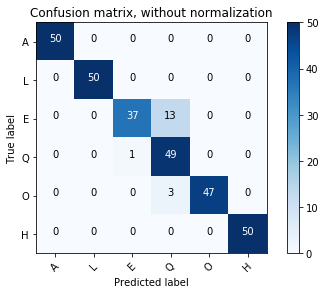

In [92]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=letters,
                      title='Confusion matrix, without normalization')
plt.show()

As we can see, most of the errors were made by mispredicting E as Q. This was unexpected because the most visually similar letters are Q and O. We took a look at the mean angles for E and Q to look for insights. As we can see below, all the angles in E have very close corresponding angles in Q. This could be partially explained by the fact that Q has many states, so it is probable the they will be close to some of E, but we believe that such explanation is not sufficient. 

It is interesting to note that, if we change the number of states in Q to 5, this problem is practically solved and we get an cross-validation accuracy of 98\%. If we, again, look at the means we see that the angles are less similar now.

In [132]:
def plot_angles(letter, states):
    X_von = create_vonmises_hmm_training_set(letter, range(1,51))
    X_gaus, lens = create_gaussian_hmm_training_set(letter, range(1,51))
    hmm_model = VonMisesHMM(n_states=states).fit(X_von)
    colors = hmm_model.predict(X_von)
    for i in range(0,states):
        plt.plot([0, np.cos(hmm_model.means_)[i]], [0, np.sin(hmm_model.means_)[i]])
        t = np.linspace(0,np.pi*2,100)
        plt.plot(np.cos(t), np.sin(t), linewidth=1)
        plt.title("Direction of means for letter " + letter)
        plt.xlim((-1,1))
        plt.ylim((-1,1))

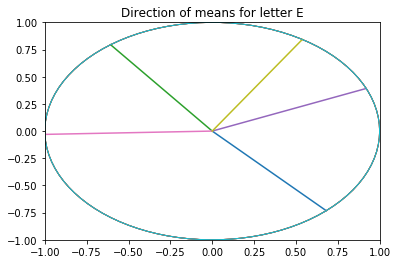

In [133]:
plot_angles(letters[2], states[2])

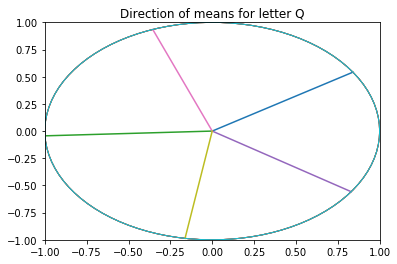

In [135]:
plot_angles(letters[3], states[3])

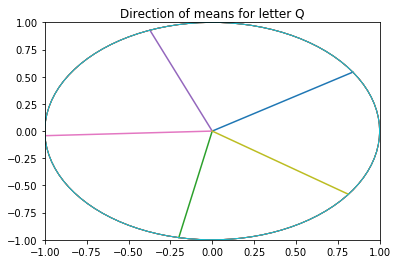

In [136]:
plot_angles(letters[3], 5)